In [ ]:
using FITSIO
using DataFrames
using Plots
pyplot()

Plots.PyPlotBackend()

In [2]:
fits_path = "D:\\Ubuntu-MPhys-Shared\\data_ftp\\nustar\\data\\obs\\00\\1\\10012001002\\event_cl\\nu10012001002A01_cl.evt.gz"
fits_file = FITS(fits_path)
fits_cord = DataFrame(X = read(fits_file[2], "X"), Y = read(fits_file[2], "Y"));


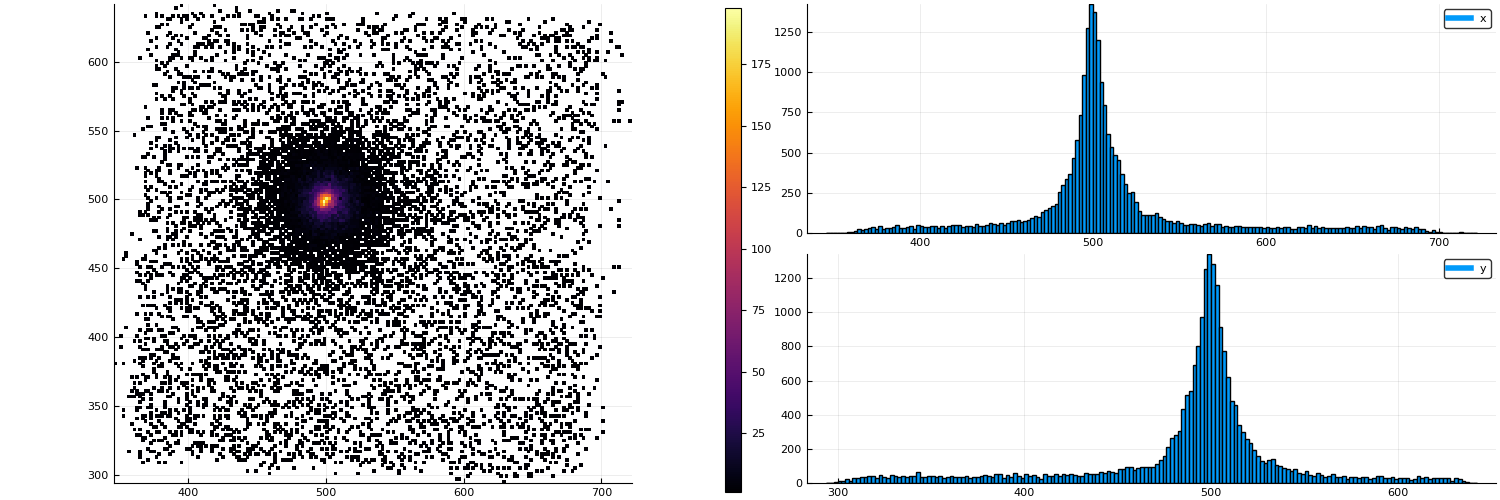

In [3]:
deleterows!(fits_cord, find(fits_cord[:, :X] .== -1)) # Remove nulled points
l = @layout([a{0.5w} [b; c]]) # Layout macro for one plot to take up half the width, other two stacked vertically
plt_hist2 = histogram2d(fits_cord[:X]*1.0, fits_cord[:Y]*1.0, bin=256, aspect_ratio=:equal) # Convert int's to float
plt_histx = histogram(fits_cord[:X]*1.0, lab="x")
plt_histy = histogram(fits_cord[:Y]*1.0, lab="y")
plot(plt_hist2, plt_histx, plt_histy, layout=l, size=(1500, 500))

The x and y histograms could have a curve fitted to them, then the source area could be defined as being the FWHM part of that curve?

In [ ]:
# Do some smoothing on the gradient using sgolay filtering so there's no shifting
function sgolay(order, frameLen)
    S = (-(frameLen-1)/2:((frameLen-1)/2)) .^ (0:order)'
    (Q, R) = qr(S)
    B = Q*Q'
    G = Q / R'

    return B, G
end


function sgolayfilt(x, order, frameLen)
    B = sgolay(order, frameLen)[1]
    x = x[:]

    @assert ndims(x) == 1

    ybegin = B[end:-1:round(Int, (frameLen-1)/2 + 2), :] * x[frameLen:-1:1, :]
    ycentre = filt(B[round(Int, (frameLen-1)./2 + 1), :], 1, x)
    yend = B[round(Int, (frameLen-1)/2):-1:1, :] * x[end:-1:end-(frameLen-1), :]

    return y = [ybegin; ycentre[frameLen:end, :]; yend]
end

sgolayfilt (generic function with 1 method)

Selected region for X: 484.0 (362) to 510.0 (521)
Selected region for Y: 484.0 (462) to 510.0 (455)



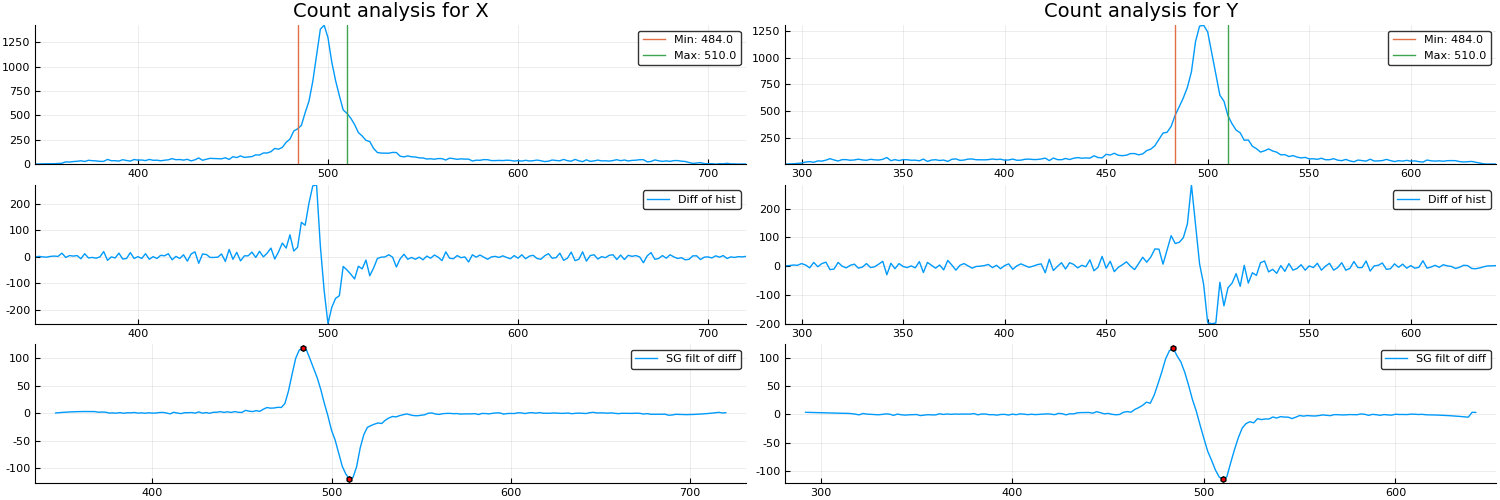

In [5]:
tmp_plts = []

for coord = [:X :Y]
    hist_y = StatsBase.fit(Histogram, fits_cord[coord], nbins=256, closed=:right).weights
    hist_x = StatsBase.fit(Histogram, fits_cord[coord], nbins=256, closed=:right).edges[1]

    plt_hist1x = plot(hist_x, hist_y, title="Count analysis for $(coord)", lab="")
    plt_hist_diff = plot(hist_x, diff(hist_y), lab="Diff of hist")

    hist_y_diff_sg = sgolayfilt(diff(hist_y), 2, 21)

    plot(hist_x, hist_y_diff_sg, lab="SG filt of diff")

    min_val, min_ind = findmax(hist_y_diff_sg) # Swapped as the 'max' value is the first one, and hence the minimum
    max_val, max_ind = findmin(hist_y_diff_sg)

    scatter!([hist_x[min_ind]], [min_val], color=:red, marker=:hex, lab="")
    plt_hist_diff_smth = scatter!([hist_x[max_ind]], [max_val], color=:red, marker=:hex, lab="")

    plot(plt_hist1x, plt_hist_diff, plt_hist_diff_smth, size=(1500, 500), layout=(3, 1))

    println("Selected region for $(coord): $(hist_x[min_ind]) ($(hist_y[min_ind])) to $(hist_x[max_ind]) ($(hist_y[max_ind]))")
    vline!([hist_x[min_ind]], lab="Min: $(hist_x[min_ind])")
    tmp_plt = vline!([hist_x[max_ind]], lab="Max: $(hist_x[max_ind])")
    
    append!(tmp_plts, [tmp_plt])
end

plot(tmp_plts[1], tmp_plts[2])

OK.... so, fit data to histograms to get a density, differentiate once to find gradient, apply sgolayfilt to smooth it, find the (hopefully only) two peaks on the gradient, use the index of those two peaks to define the minimum and maximum coordinates:

# Find Source Function

In [ ]:
function find_source_diff(data; filt_flag=true)
    data_out = copy(data)
    bnds_out = DataFrame()
    
    for coord in names(data)
        hist_x = StatsBase.fit(Histogram, data_out[coord], nbins=256, closed=:right).edges[1]
        hist_y = StatsBase.fit(Histogram, data_out[coord], nbins=256, closed=:right).weights

        if filt_flag
            hist_y_diff_sg = sgolayfilt(diff(hist_y), 2, 21)
        else
            hist_y_diff_sg = diff(hist_y)
        end

        min_val, min_ind = findmax(hist_y_diff_sg) # Swapped as the 'max' value is the first one, and hence the minimum
        max_val, max_ind = findmin(hist_y_diff_sg)

        min_val = Int(hist_x[min_ind])
        max_val = Int(hist_x[max_ind])
        
        println("Selected region for $(coord): $(hist_x[min_ind]) ($(hist_y[min_ind])) to $(hist_x[max_ind]) ($(hist_y[max_ind]))")

        data_out = data_out[min_val .< data_out[coord] .< max_val, :]
    end
    
    return data_out
end

find_source_diff (generic function with 1 method)

In [ ]:
function plt_src_graphs(fits_cord, fits_cord_source)
    l2 = @layout([a{0.3w} b{0.3w} [c; d]]) # Layout macro for one plot to take up half the width, other two stacked vertically
    plt_hist2 = histogram2d(fits_cord_source[:X]*1.0, fits_cord_source[:Y]*1.0, aspect_ratio=:equal) # Convert int's to float
    plt_histx = histogram(fits_cord_source[:X]*1.0, lab="x")
    plt_histy = histogram(fits_cord_source[:Y]*1.0, lab="y")

    histogram2d(fits_cord[:X]*1.0, fits_cord[:Y]*1.0, bin=256, aspect_ratio=:equal, xlim=(minimum(fits_cord_source[:X])*0.9, maximum(fits_cord_source[:X])*1.1), ylim=(minimum(fits_cord_source[:Y])*0.9, maximum(fits_cord_source[:Y])*1.1), legend=false)
    vline!([minimum(fits_cord_source[:X])], linewidth=2, color=:cyan); vline!([maximum(fits_cord_source[:X])], linewidth=2, color=:cyan)
    plt_hist_sel = hline!([minimum(fits_cord_source[:Y])], linewidth=2, color=:cyan); hline!([maximum(fits_cord_source[:Y])], linewidth=2, color=:cyan)

    plot(plt_hist_sel, plt_hist2, plt_histx, plt_histy, layout=l2, size=(1500, 500))
end

plt_src_graphs (generic function with 1 method)

Selected region for X: 484.0 (362) to 510.0 (521)
Selected region for Y: 484.0 (254) to 510.0 (249)



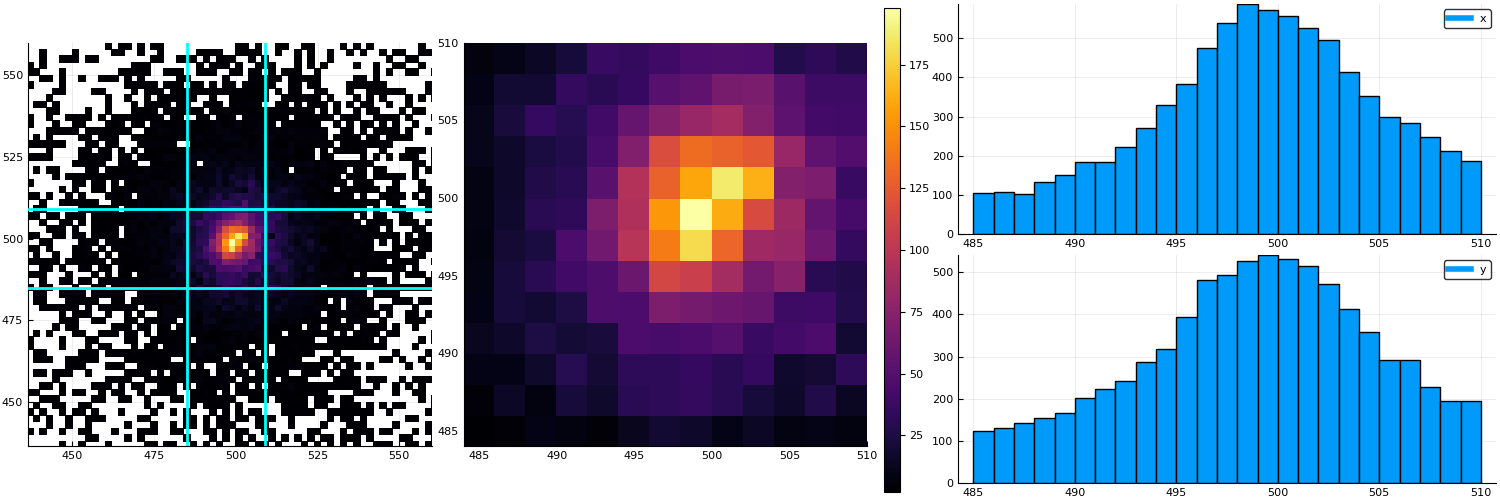

In [8]:
fits_cord_source_diff = find_source_diff(fits_cord; filt_flag=true)

plt_src_graphs(fits_cord, fits_cord_source_diff)

Or more basic FWHM:

Max y val 1024.3376920562273, ind 77, pos 498.0
FWXM: 409.73507682249095
480:518
Max y val 1014.2811376266754, ind 104, pos 498.0
FWXM: 405.7124550506702
478:516



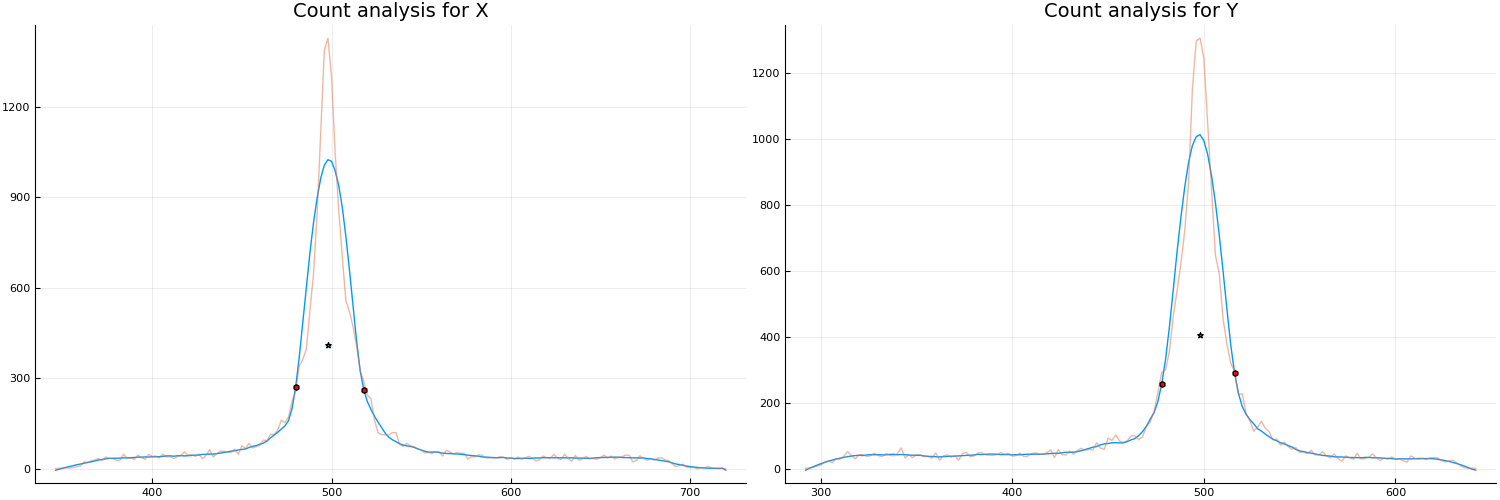

In [9]:
coord = :X
prcnt = 0.4
filt_flag = true

tmp_plts = []

for coord = [:X :Y]
    hist_y = StatsBase.fit(Histogram, fits_cord[coord], nbins=256, closed=:right).weights
    hist_x = StatsBase.fit(Histogram, fits_cord[coord], nbins=256, closed=:right).edges[1]
    
    if filt_flag
        hist_y_old = copy(hist_y)
        hist_y = sgolayfilt(hist_y, 2, 21)
    end
    
    max_y_val, max_y_ind  = findmax(hist_y)

    println("Max y val $(max_y_val), ind $(max_y_ind), pos $(hist_x[max_y_ind])")
    println("FWXM: $(max_y_val*prcnt)")

    upper_ind = Int(max_y_ind + findfirst(hist_y[max_y_ind:end] .<= max_y_val*prcnt))
    lower_ind = Int(max_y_ind - findfirst(hist_y[max_y_ind:-1:1] .<= max_y_val*prcnt))

    if filt_flag
        plot(hist_x, hist_y, title="Count analysis for $(coord)", lab="")
        plot!(hist_x, hist_y_old, title="Count analysis for $(coord)", lab="", alpha=0.5)
    end

    scatter!([hist_x[upper_ind]], [hist_y[upper_ind]], color=:red, marker=:hex, lab="")
    scatter!([hist_x[lower_ind]], [hist_y[lower_ind]], color=:red, marker=:hex, lab="")
    plt_tmp = scatter!([hist_x[max_y_ind]], [max_y_val*prcnt], color=:cyan, marker=:star, lab="")
    
    println(Int(hist_x[lower_ind]), ":", Int(hist_x[upper_ind]))
    
    append!(tmp_plts, [plt_tmp])
end

plot(tmp_plts[1], tmp_plts[2], layout=(1, 2), size=(1500, 500))

In [ ]:
function find_source_fwxm(data; prcnt=0.5, filt_flag=true)
    data_out = copy(data)
    bnds_out = DataFrame()
    
    for coord in names(data)
        hist_y = StatsBase.fit(Histogram, fits_cord[coord], nbins=256, closed=:right).weights
        hist_x = StatsBase.fit(Histogram, fits_cord[coord], nbins=256, closed=:right).edges[1]

        if filt_flag
            hist_y_old = copy(hist_y)
            hist_y = sgolayfilt(hist_y, 2, 21)
        end

        max_y_val, max_y_ind  = findmax(hist_y)
        
        max_ind = Int(max_y_ind + findfirst(hist_y[max_y_ind:end] .<= max_y_val*prcnt))
        min_ind = Int(max_y_ind - findfirst(hist_y[max_y_ind:-1:1] .<= max_y_val*prcnt))
        
        println("Selected region for $(coord): $(hist_x[min_ind]) ($(hist_y[min_ind])) to $(hist_x[max_ind]) ($(hist_y[max_ind]))")
        
        data_out = data_out[Int(hist_x[min_ind]) .< data_out[coord] .< Int(hist_x[max_ind]), :]
    end
    
    return data_out
end

find_source_fwxm (generic function with 1 method)

Selected region for X: 484.0 (362) to 510.0 (521)
Selected region for Y: 484.0 (254) to 510.0 (249)



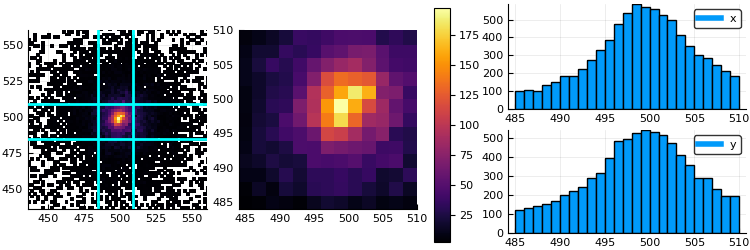

In [11]:
fits_cord_source_diff = find_source_diff(fits_cord; filt_flag=true)

plts_cord_source_diff = plt_src_graphs(fits_cord, fits_cord_source_diff)

plot(plts_cord_source_diff, size=(1500/2, 500/2))

Cool, apparently a way to convert points to a density is to use Kernel Density Estimation, conveniently [KernelDesnity.jl](https://github.com/JuliaStats/KernelDensity.jl) does just that

In [12]:
using KernelDensity
using StatPlots

In [13]:
fits_kde = kde((fits_cord[:X], fits_cord[:Y]))
println("kde type has fields: ", fieldnames(typeof(fits_kde)))

kde type has fields: Symbol[:x, :y, :density]



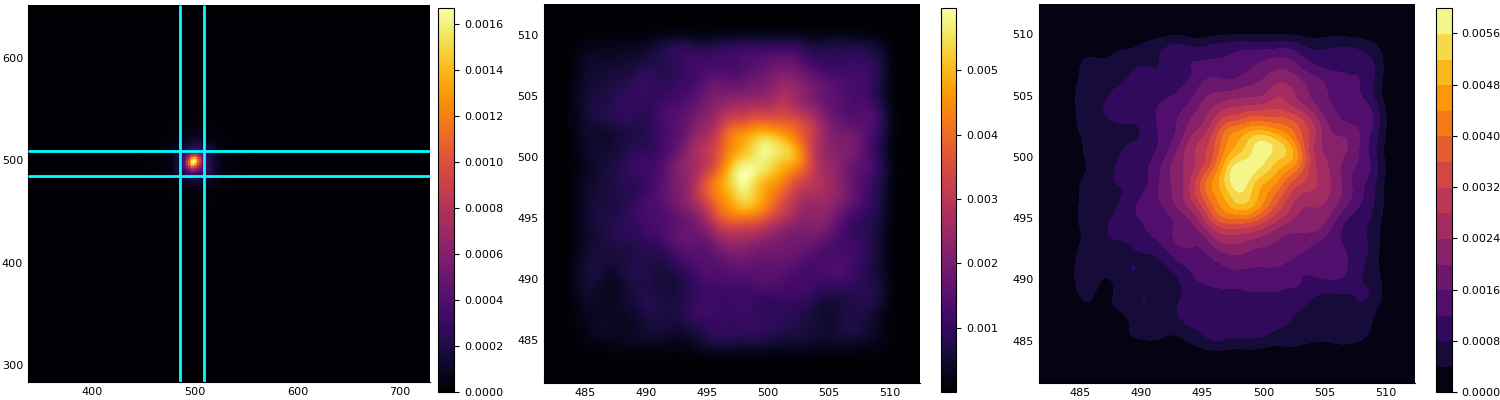

In [14]:
plt_heat_kde_raw = heatmap(fits_kde, aspect_ratio=:equal, size=(800, 800))
vline!([minimum(fits_cord_source_diff[:X])], linewidth=2, color=:cyan, lab=""); vline!([maximum(fits_cord_source_diff[:X])], linewidth=2, color=:cyan, lab="")
hline!([minimum(fits_cord_source_diff[:Y])], linewidth=2, color=:cyan, lab=""); hline!([maximum(fits_cord_source_diff[:Y])], linewidth=2, color=:cyan, lab="")

plt_heat_kde_sel = heatmap(kde((fits_cord_source_diff[:X], fits_cord_source_diff[:Y])), size=(800, 800), aspect_ratio=:equal)

plt_contour_kde = contour(kde((fits_cord_source_diff[:X], fits_cord_source_diff[:Y])), fill=true, size=(800, 500), aspect_ratio=:equal)

plot(plt_heat_kde_raw, plt_heat_kde_sel, plt_contour_kde, size=(1500, 400), layout=(1, 3))

Selected region for X: 488.0 (718.4485125858123) to 508.0 (770.3713631905854)
Selected region for Y: 488.0 (763.050670153645) to 508.0 (710.0490356325598)



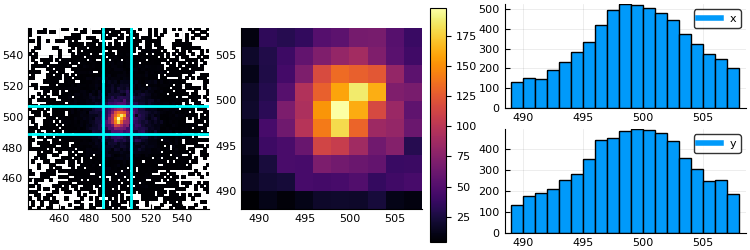

In [15]:
fits_cord_source_fwxm = find_source_fwxm(fits_cord; prcnt=0.85, filt_flag=true)

plts_cord_source_fwxm = plt_src_graphs(fits_cord, fits_cord_source_fwxm)

plot(plts_cord_source_fwxm, size=(1500/2, 500/2))


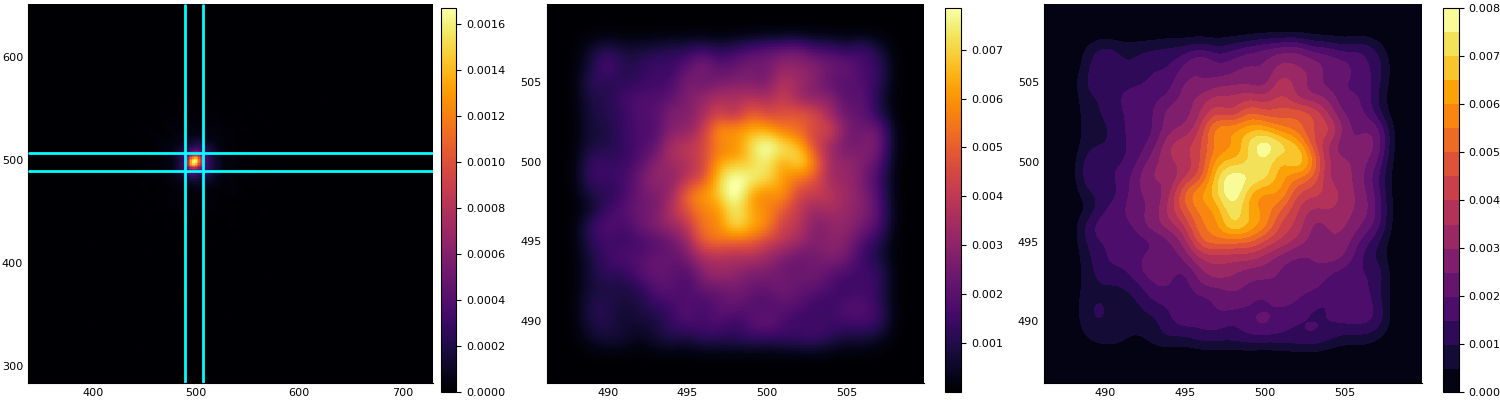

In [ ]:
plt_heat_kde_raw = heatmap(fits_kde, aspect_ratio=:equal, size=(800, 800))
vline!([minimum(fits_cord_source_fwxm[:X])], linewidth=2, color=:cyan, lab=""); vline!([maximum(fits_cord_source_fwxm[:X])], linewidth=2, color=:cyan, lab="")
hline!([minimum(fits_cord_source_fwxm[:Y])], linewidth=2, color=:cyan, lab=""); hline!([maximum(fits_cord_source_fwxm[:Y])], linewidth=2, color=:cyan, lab="")

plt_heat_kde_sel = heatmap(kde((fits_cord_source_fwxm[:X], fits_cord_source_fwxm[:Y])), size=(800, 800), aspect_ratio=:equal)

plt_contour_kde = contour(kde((fits_cord_source_fwxm[:X], fits_cord_source_fwxm[:Y])), fill=true, size=(800, 500), aspect_ratio=:equal)

plot(plt_heat_kde_raw, plt_heat_kde_sel, plt_contour_kde, size=(1500, 400), layout=(1, 3))

# Creating src.reg and bkg.reg

The output should be of the format:
```
# Region file format: DS9 version 4.1
global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1
fk5
circle(19:58:21.593,+35:11:57.46,10")
```

In [17]:
type pixel_scale
    x_ref_pix
    x_ref_deg
    x_ref_scl

    y_ref_pix
    y_ref_deg
    y_ref_scl
end

In [ ]:
function read_pixel_scale(fits_evt_table)
    read_header(fits_evt_table) # Shows full header for the events table
    # Looking through, found that the reference pixel, coordinates and scale are given by:
    #read_key(fits_file, "key_name" OR position) # Shows key name, value and description

    x_ref_pix = read_key(fits_evt_table, "TCRPX38")[1] # X ref pix
    x_ref_deg = read_key(fits_evt_table, "TCRVL38")[1] # X ref deg
    x_ref_scl = read_key(fits_evt_table, "TCDLT38")[1] # X ref scale

    y_ref_pix = read_key(fits_evt_table, "TCRPX39")[1] # Y ref pix
    y_ref_deg = read_key(fits_evt_table, "TCRVL39")[1] # Y ref deg
    y_ref_scl = read_key(fits_evt_table, "TCDLT39")[1] # Y ref scale

    return pixel_scale(x_ref_pix, x_ref_deg, x_ref_scl, y_ref_pix, y_ref_deg, y_ref_scl)
end

read_pixel_scale (generic function with 1 method)

In [19]:
px_scale = read_pixel_scale(fits_file[2])

pixel_scale(500.5, 187.2779, -0.0006828076, 500.5, 2.0525, 0.0006828076)